# Early Testing Docling 

In [1]:
import json
import logging
import time
from pathlib import Path
from tqdm.notebook import tqdm

In [2]:
from docling.datamodel.accelerator_options import AcceleratorDevice, AcceleratorOptions
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import (
    PdfPipelineOptions,
)
from docling.document_converter import DocumentConverter, PdfFormatOption

In [17]:
type(conv_result.document)

docling_core.types.doc.document.DoclingDocument

In [21]:
from docling_core.types.doc import BoundingBox, DocItem, DoclingDocument, NodeItem

In [3]:
_log = logging.getLogger(__name__)

In [4]:
# Docling Parse with EasyOCR
# ----------------------
pipeline_options = PdfPipelineOptions()
pipeline_options.do_ocr = True
pipeline_options.do_table_structure = True
pipeline_options.table_structure_options.do_cell_matching = True
pipeline_options.ocr_options.lang = ["en"]
pipeline_options.accelerator_options = AcceleratorOptions(
    num_threads=32, device=AcceleratorDevice.AUTO
)

doc_converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
    }
)

In [80]:
pipeline_options.layout_options

LayoutOptions(create_orphan_clusters=True, keep_empty_clusters=False, model_spec=LayoutModelConfig(name='docling_layout_heron', repo_id='ds4sd/docling-layout-heron', revision='main', model_path='', supported_devices=[<AcceleratorDevice.CPU: 'cpu'>, <AcceleratorDevice.CUDA: 'cuda'>, <AcceleratorDevice.MPS: 'mps'>]), skip_cell_assignment=False)

In [5]:
data_folder = Path("/workspace/extraction/testdata/")
doc_paths = []
if data_folder.exists() and data_folder.is_dir():
    files_found = []
    for item in data_folder.iterdir():
        if item.is_file():
            doc_paths.append(item)
doc_paths = sorted(doc_paths)

## Export results
output_dir = Path("scratch")
output_dir.mkdir(parents=True, exist_ok=True)

In [74]:
start_time = time.time()
conv_result = doc_converter.convert(doc_paths[0])
end_time = time.time() - start_time
_log.info(f"Document converted in {end_time:.2f} seconds.")

2025-09-11 04:26:21,060 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-09-11 04:26:21,763 - INFO - Going to convert document batch...
2025-09-11 04:26:21,765 - INFO - Processing document 01.pdf
2025-09-11 04:26:54,215 - INFO - Finished converting document 01.pdf in 33.93 sec.
2025-09-11 04:26:54,225 - INFO - Document converted in 33.95 seconds.


In [23]:
original_document = conv_result.document
filtered_texts = []
labels = []
for element in original_document.texts:
    labels.append(element.label)
    
labels = set(labels)
# filtered_document = DoclingDocument

In [56]:
labels

{<DocItemLabel.CAPTION: 'caption'>,
 <DocItemLabel.FOOTNOTE: 'footnote'>,
 <DocItemLabel.LIST_ITEM: 'list_item'>,
 <DocItemLabel.PAGE_FOOTER: 'page_footer'>,
 <DocItemLabel.PAGE_HEADER: 'page_header'>,
 <DocItemLabel.SECTION_HEADER: 'section_header'>,
 <DocItemLabel.TEXT: 'text'>}

In [75]:
element

TextItem(self_ref='#/texts/961', parent=RefItem(cref='#/body'), children=[], content_layer=<ContentLayer.FURNITURE: 'furniture'>, label=<DocItemLabel.PAGE_FOOTER: 'page_footer'>, prov=[ProvenanceItem(page_no=31, bbox=BoundingBox(l=318.161, t=25.647022949218808, r=543.278, b=18.290022949218724, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 60))], orig='Developmental Cell 56 , 1164-1181.e1-e12, April 19, 2021 e12', text='Developmental Cell 56 , 1164-1181.e1-e12, April 19, 2021 e12', formatting=None, hyperlink=None)

In [82]:
from docling.utils.layout_postprocessor import LayoutPostprocessor
from docling_core.types.doc import DocItemLabel

# Monkey patch the confidence thresholds
def create_custom_converter(confidence_config):
    # Store original thresholds
    original_thresholds = LayoutPostprocessor.CONFIDENCE_THRESHOLDS.copy()
    
    # Create new thresholds - set very high values for unwanted labels
    custom_thresholds = original_thresholds.copy()
    
    # Set impossible thresholds (>1.0) for labels not in your config
    for label in DocItemLabel:
        if label not in confidence_config:
            custom_thresholds[label] = 2.0  # Impossible threshold
        else:
            custom_thresholds[label] = confidence_config[label]
    
    # Apply the patch
    LayoutPostprocessor.CONFIDENCE_THRESHOLDS = custom_thresholds
    
    # Create converter with these settings
    pipeline_options = PdfPipelineOptions()
    pipeline_options.do_ocr = True
    pipeline_options.do_table_structure = True
    pipeline_options.table_structure_options.do_cell_matching = True
    pipeline_options.ocr_options.lang = ["en"]
    pipeline_options.accelerator_options = AcceleratorOptions(
        num_threads=32, device=AcceleratorDevice.AUTO
    )
    
    converter = DocumentConverter(
        format_options={
            InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
        }
    )
    
    # Return both converter and restoration function
    def restore_thresholds():
        LayoutPostprocessor.CONFIDENCE_THRESHOLDS = original_thresholds
    
    return converter, restore_thresholds

In [88]:
# Usage
confidence_config = {
    DocItemLabel.SECTION_HEADER: 0.8,
    DocItemLabel.TEXT: 0.95,
    # Only include labels you want to keep
}

# Create custom converter
custom_converter, restore_fn = create_custom_converter(confidence_config)

try:
    # Convert with custom confidence filtering
    conv_result = custom_converter.convert(doc_paths[0])
    
    # Export to markdown (should work without hierarchy errors)
    markdown_content = conv_result.document.export_to_markdown()
    
finally:
    # Always restore original thresholds
    restore_fn()

2025-09-11 06:10:06,468 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-09-11 06:10:06,675 - INFO - Going to convert document batch...
2025-09-11 06:10:06,676 - INFO - Initializing pipeline for StandardPdfPipeline with options hash 0e1a47abb5af401bdb77d892261e0a3d
2025-09-11 06:10:06,677 - INFO - Accelerator device: 'cuda:0'
2025-09-11 06:10:09,809 - INFO - Accelerator device: 'cuda:0'
2025-09-11 06:10:12,304 - INFO - Accelerator device: 'cuda:0'
2025-09-11 06:10:13,578 - INFO - Processing document 01.pdf
2025-09-11 06:10:49,184 - INFO - Finished converting document 01.pdf in 42.72 sec.


In [87]:
debug_dir = Path("testdata/debug/")
doc_filename = conv_result.input.file.stem
with (debug_dir / f"{doc_filename}.md").open("w", encoding="utf-8") as fp:
    fp.write(conv_result.document.export_to_markdown())

In [86]:
output_dir / f"{doc_filename}.md"

PosixPath('scratch/01.md')

In [8]:
for doc_path in tqdm(doc_paths):
    start_time = time.time()
    conv_result = doc_converter.convert(doc_path)
    end_time = time.time() - start_time
    _log.info(f"Document converted in {end_time:.2f} seconds.")

    doc_filename = conv_result.input.file.stem
    
    # Export Deep Search document JSON format:
    with (output_dir / f"{doc_filename}.json").open("w", encoding="utf-8") as fp:
        fp.write(json.dumps(conv_result.document.export_to_dict()))

    # Export Markdown format:
    with (output_dir / f"{doc_filename}.md").open("w", encoding="utf-8") as fp:
        fp.write(conv_result.document.export_to_markdown())

  0%|          | 0/15 [00:00<?, ?it/s]

2025-09-09 10:31:54,103 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-09-09 10:31:54,139 - INFO - Going to convert document batch...
2025-09-09 10:31:54,140 - INFO - Processing document 01.pdf
2025-09-09 10:32:17,571 - INFO - Finished converting document 01.pdf in 23.47 sec.
2025-09-09 10:32:17,597 - INFO - Document converted in 23.49 seconds.
2025-09-09 10:32:17,744 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-09-09 10:32:17,770 - INFO - Going to convert document batch...
2025-09-09 10:32:17,772 - INFO - Processing document 02.pdf
2025-09-09 10:32:41,047 - INFO - Finished converting document 02.pdf in 23.30 sec.
2025-09-09 10:32:41,062 - INFO - Document converted in 23.32 seconds.
2025-09-09 10:32:41,198 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-09-09 10:32:41,225 - INFO - Going to convert document batch...
2025-09-09 10:32:41,226 - INFO - Processing document 03.pdf
2025-09-09 10:33:08,012 - INFO - Finished converting document 03.pdf in 26.8

In [12]:
## Export results
output_dir = Path("scratch")
output_dir.mkdir(parents=True, exist_ok=True)
doc_filename = conv_result.input.file.stem

# Export Deep Search document JSON format:
with (output_dir / f"{doc_filename}.json").open("w", encoding="utf-8") as fp:
    fp.write(json.dumps(conv_result.document.export_to_dict()))

# Export Text format:
# with (output_dir / f"{doc_filename}.txt").open("w", encoding="utf-8") as fp:
#     fp.write(conv_result.document.export_to_text())

# Export Markdown format:
# with (output_dir / f"{doc_filename}.md").open("w", encoding="utf-8") as fp:
#     fp.write(conv_result.document.export_to_markdown())

# Export Document Tags format:
# with (output_dir / f"{doc_filename}.doctags").open("w", encoding="utf-8") as fp:
#     fp.write(conv_result.document.export_to_document_tokens())

# Document Structure

In [1]:
from pathlib import Path
import re
def extract_results(text):
    """
    This function extracts (abstract + introduction) and results.
    """
    SEP1 = r"\n## results?\n"
    SEP2 = r"\n## discussion\n"

    context, results = re.split(SEP1, text, flags=re.IGNORECASE)
    results = re.split(SEP2, results, flags=re.IGNORECASE)[0]
    return context, results

def extract_subsections(text):
    # \n##          -> A newline, two hashes, and a space.
    # (?!Figure)    -> A "negative lookahead". Asserts that the following text is NOT "Figure".
    #                This is the key part for the exclusion.
    # [^\n]+        -> Matches one or more characters that are NOT a newline (the header text).
    # \n            -> The final newline ending the header line.
    # wrapping the whole pattern in a capturing group (...)
    SEP = r"(\n## (?!Figure)[^\n]+\n)"
    parts = re.split(SEP, text, flags=re.IGNORECASE)
    subsections = [parts[0]]
    for i in range(1, len(parts), 2):
        sep = parts[i]
        chunk = parts[i+1]
        subsections.append(sep + chunk)
    
    subsections = [x.strip() for x in subsections if x.strip()]
    
    return subsections

In [4]:
markdown_dir = Path("../markdown/ocr/")
md_files = sorted(list(markdown_dir.glob("*.md")))

In [10]:
import json
input_file_path = md_files[5]
with open(input_file_path, "r") as f:
    data = f.read()

prefix, results = extract_results(data)
subsections = extract_subsections(results)

output = {"prefix": prefix, "results": subsections}
with open("output.json", "w") as f:
    json.dump(output, f, indent=4)

In [27]:
template = """
Your task is to extract and concisely summarize key information from a provided `RESULTS subsection`. You will be given `Prefix Context` (including ABSTRACT/SUMMARY and INTRODUCTION) to aid your understanding.

Your output should be a highly concise summary structured into three distinct sections, if applicable. Each section should be presented as a single, brief statement or a very short list.

- **Experiments**: Briefly describe the experimental methods used.
- **Conclusion**: State a high-certainty finding derived directly from the experimental results. Avoid any speculation, hypotheses, or interpretations beyond the immediate data.
- **Implication**: Briefly suggest a direct consequence or significance of the observed data and conclusion.

If any of these three sections cannot be clearly and concisely identified within the `RESULTS subsection`, simply omit that section from your output.

---

# Prefix Context:
{prefix}

# RESULTS subsection:
{subsection}
""".strip()

In [31]:
N = len(output["results"])
output = json.load(open("output.json"))

prompts = []
for i in range(N):
    prompt = template.format(
        prefix=output["prefix"],
        subsection=output["results"][i]
    )
    prompts.append(prompt)

In [26]:
import json
import requests
import time
import argparse
import threading
import os
from tqdm import tqdm
from typing import List, Dict, Any, Union

def send_request(url, model, data, request_id, results, errors, semaphore, pbar):
    """Sends a single request to the vLLM server."""
    headers = {"Content-Type": "application/json"}
    prompt = data.get("prompt")
    pload = {
        "model": model,
        "messages": [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.7,
        "top_p": 0.8,
        "stop": ["<|eot_id|>", "<|end_of_text|>"],
        # "repetition_penalty": 1.05,
        "presence_penalty": 1.1,
        "max_tokens": 1024,
        "stream": False
    }

    try:
        semaphore.acquire()
        response = requests.post(url, headers=headers, json=pload, timeout=1200)
        response.raise_for_status()

        response_json = response.json()
        results[request_id] = {
            "request_id": request_id,
            # "prompt": prompt,
            "response": response_json["choices"][0]["message"]["content"],
            **data
            
        }
    except requests.exceptions.RequestException as e:
        errors[request_id] = str(e)
        results[request_id] = {
            # "request_id": request_id,
            "prompt": prompt,
            "response": None,  # Indicate failed requests with response = None
            **data
        }
    finally:
        semaphore.release()
        pbar.update(1)

def process_prompts(prompts: Union[List[str], List[Dict[str, Any]]], 
                   model: str = "llama2-7b-hf",
                   url: str = "localhost:8001",
                   concurrent_requests: int = 10,
                   results_file: str = None) -> tuple:
    """
    Process a list of prompts using vLLM server.
    
    Args:
        prompts: List of prompt strings or dictionaries containing prompt data
        model: Model name for inference
        url: Server URL
        concurrent_requests: Number of concurrent requests
        results_file: Optional file to save results
    
    Returns:
        tuple: (results, stats, errors)
    """
    server_url = f"http://{url}/v1/chat/completions"
    
    # Convert prompts to standardized format
    dataset = []
    for i, prompt in enumerate(prompts):
        if isinstance(prompt, str):
            dataset.append({"prompt": prompt, "id": i})
        elif isinstance(prompt, dict):
            # Ensure the dict has a prompt field
            if "prompt" not in prompt:
                raise ValueError(f"Dictionary at index {i} must contain 'prompt' field")
            dataset.append(prompt)
        else:
            raise ValueError(f"Invalid prompt type at index {i}: {type(prompt)}")

    results = {}
    errors = {}
    start_time = time.time()

    semaphore = threading.Semaphore(concurrent_requests)

    with tqdm(total=len(dataset), desc="Processing requests") as pbar:
        threads = []
        for i, data in enumerate(dataset):
            thread = threading.Thread(
                target=send_request, 
                args=(
                    server_url, 
                    model, 
                    data, i, 
                    results, 
                    errors, 
                    semaphore, 
                    pbar
                )
            )
            threads.append(thread)
            thread.start()

        for thread in threads:
            thread.join()

    end_time = time.time()
    elapsed_time = end_time - start_time

    # Sort results by request_id
    sorted_results = [results[i] for i in sorted(results.keys())]

    # Write results to file if specified
    if results_file:
        with open(results_file, "w") as outfile:
            for result in sorted_results:
                json.dump(result, outfile)
                outfile.write('\n')

    # Prepare statistics
    successful_requests = sum(1 for res in results.values() if res["response"] is not None)
    total_requests = len(dataset)
    throughput = successful_requests / elapsed_time if elapsed_time > 0 else 0
    failed_request_ids = list(errors.keys())

    stats = {
        "total_requests": total_requests,
        "successful_requests": successful_requests,
        "failed_requests": total_requests - successful_requests,
        "failed_request_ids": failed_request_ids,
        "elapsed_time": elapsed_time,
        "throughput": throughput,
    }

    return sorted_results, stats, errors

In [33]:
results, stats, errors = process_prompts(
    prompts=prompts,
    model="Qwen3-8B",
    url="localhost:8000",
    concurrent_requests=20,
    results_file="output.jsonl"
)

Processing requests: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.77s/it]


# VLM

In [1]:
from docling.datamodel import vlm_model_specs
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import (
    VlmPipelineOptions,
)
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.pipeline.vlm_pipeline import VlmPipeline

In [2]:
source = "../testdata/01.pdf"

In [3]:
converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_cls=VlmPipeline,
        ),
    }
)

In [4]:
doc = converter.convert(source=source).document

2025-09-12 09:42:27,062 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-09-12 09:42:27,109 - INFO - Going to convert document batch...
2025-09-12 09:42:27,110 - INFO - Initializing pipeline for VlmPipeline with options hash b7500fc58af7f032441777a46700c153
2025-09-12 09:42:27,140 - INFO - Accelerator device: 'cuda:0'
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fcf95b67a50>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



### ---

In [1]:
import json
import logging
import os
from pathlib import Path
from typing import Optional

import requests
from docling_core.types.doc.page import SegmentedPage
from dotenv import load_dotenv

from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import (
    VlmPipelineOptions,
)
from docling.datamodel.pipeline_options_vlm_model import ApiVlmOptions, ResponseFormat
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.pipeline.vlm_pipeline import VlmPipeline

In [2]:
def vlm_options(model: str, prompt: str, format: ResponseFormat):
    options = ApiVlmOptions(
        url="http://localhost:8000/v1/chat/completions",  # the default LM Studio
        params=dict(
            model=model,
        ),
        prompt=prompt,
        timeout=90,
        scale=1.0,
        response_format=format,
    )
    return options

In [33]:
data_folder = Path("../testdata/")
input_doc_path = data_folder / "05.pdf"

# input_doc_path = "https://arxiv.org/pdf/1706.03762"
pipeline_options = VlmPipelineOptions(
    enable_remote_services=True  # <-- this is required!
)

In [37]:
pipeline_options.vlm_options = vlm_options(
    model="SmolDocling-256M-preview",
    prompt="docling please.",
    format=ResponseFormat.DOCTAGS,
)
doc_converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_options=pipeline_options,
            pipeline_cls=VlmPipeline,
        )
    }
)


In [38]:
result = doc_converter.convert(input_doc_path)
# print(result.document.export_to_markdown())

2025-09-13 07:04:25,826 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-09-13 07:04:25,855 - INFO - Going to convert document batch...
2025-09-13 07:04:25,856 - INFO - Initializing pipeline for VlmPipeline with options hash 0de142b88f7413732d638b3b054a5ce1
2025-09-13 07:04:25,857 - INFO - Processing document 05.pdf
2025-09-13 07:06:17,085 - INFO - Finished converting document 05.pdf in 111.26 sec.


In [15]:
result.document.save_as_html("vlm.html")

In [17]:
# Save the document as a .doctags file
result.document.save_as_doctags(filename="vlm.doctags")

In [34]:
# print(result.document.export_to_markdown())

# Document Layout Analysis

In [6]:
from pathlib import Path
from typing import List, Optional, Tuple
from PIL import Image
import numpy as np

from docling.backend.pypdfium2_backend import PyPdfiumDocumentBackend
from docling.datamodel.document import InputDocument
from docling.datamodel.base_models import InputFormat
from docling.datamodel.accelerator_options import AcceleratorOptions
from docling.datamodel.pipeline_options import LayoutOptions
from docling.datamodel.base_models import BoundingBox, Cluster
from docling.models.layout_model import LayoutModel
from docling_core.types.doc import DocItemLabel
from PIL import ImageDraw, ImageFont
import random

COLOR_MAP = {
    DocItemLabel.TEXT: "blue",
    DocItemLabel.SECTION_HEADER: "red", 
    DocItemLabel.TABLE: "green",
    DocItemLabel.PICTURE: "purple",
    DocItemLabel.CAPTION: "orange",
    DocItemLabel.FOOTNOTE: "brown",
    DocItemLabel.PAGE_HEADER: "pink",
    DocItemLabel.PAGE_FOOTER: "pink",
    DocItemLabel.LIST_ITEM: "cyan",
    DocItemLabel.FORMULA: "yellow",
    DocItemLabel.CODE: "gray",
}

def analyze_layout(
    input_file_path: str, 
    page: int = 0,
    layout_model: str = None
) -> Tuple[Image.Image, List[Cluster]]:
    """
    Analyze layout of a specific page in a PDF file.
    
    Args:
        input_file_path: Path to the PDF file
        page: Page number to analyze (0-based indexing)
        
    Returns:
        Tuple of (page_image, layout_clusters)
        - page_image: PIL Image of the page
        - layout_clusters: List of Cluster objects with bounding boxes and labels
    """
    
    # 2. Load PDF using InputDocument (it handles backend internally)
    file_path = Path(input_file_path)
    input_doc = InputDocument(
        path_or_stream=file_path,
        format=InputFormat.PDF,
        backend=PyPdfiumDocumentBackend
    )
    if not input_doc.valid:
        raise ValueError(f"Document {file_path} is not valid")    
    
    # 3. Load specific page
    backend = input_doc._backend
    if page >= backend.page_count():
        raise ValueError(f"Page {page} does not exist. Document has {backend.page_count()} pages.")
    
    page_backend = backend.load_page(page)
    
    if not page_backend.is_valid():
        raise ValueError(f"Page {page} is not valid")
    
    # 4. Get page image (this is what the layout model expects)
    page_image = page_backend.get_page_image(scale=2.0)
    page_size = page_backend.get_size()
    
    # 5. Run layout prediction
    predictions = layout_model.layout_predictor.predict_batch([page_image])
    page_predictions = predictions[0]
    
    # 6. Convert predictions to clusters
    clusters = []
    for ix, pred_item in enumerate(page_predictions):
        # Convert label string to DocItemLabel enum
        label_str = pred_item["label"].lower().replace(" ", "_").replace("-", "_")
        label = DocItemLabel(label_str)
        
        cluster = Cluster(
            id=ix,
            label=label,
            confidence=pred_item["confidence"],
            bbox=BoundingBox.model_validate(pred_item),
            cells=[]
        )
        clusters.append(cluster)
    
    # 7. Cleanup
    page_backend.unload()
    backend.unload()
    
    return page_image, clusters

def mask_layout(
    image: Image.Image, 
    clusters: List[Cluster],
    allowed_labels: List[str]
):
    # Create a copy to avoid modifying original
    annotated_image = image.copy()
    draw = ImageDraw.Draw(annotated_image)

    for cluster in clusters:
        if cluster.label in allowed_labels: continue
            
        # Masking unwanted components
        color = "white"
        bbox = cluster.bbox
        rect = [bbox.l, bbox.t, bbox.r, bbox.b]
        draw.rectangle(rect, fill=color)
        
    return annotated_image

In [2]:
if __name__ == "__main__":
    # 1. Initialize the layout model
    layout_model = LayoutModel(
        artifacts_path=None,  # Will auto-download models
        accelerator_options=AcceleratorOptions(),  # Use defaults (CPU)
        options=LayoutOptions()  # Use default layout options
    )
    

In [26]:
if __name__ == "__main__":
    ## INPUT
    input_file_path = "../testdata/05.pdf"
    page = 0
    allowed_labels = [
        DocItemLabel.TEXT, DocItemLabel.SECTION_HEADER
    ]

    image, clusters = analyze_layout(input_file_path, page, layout_model)
    masked_image = mask_layout(image, clusters, allowed_labels)

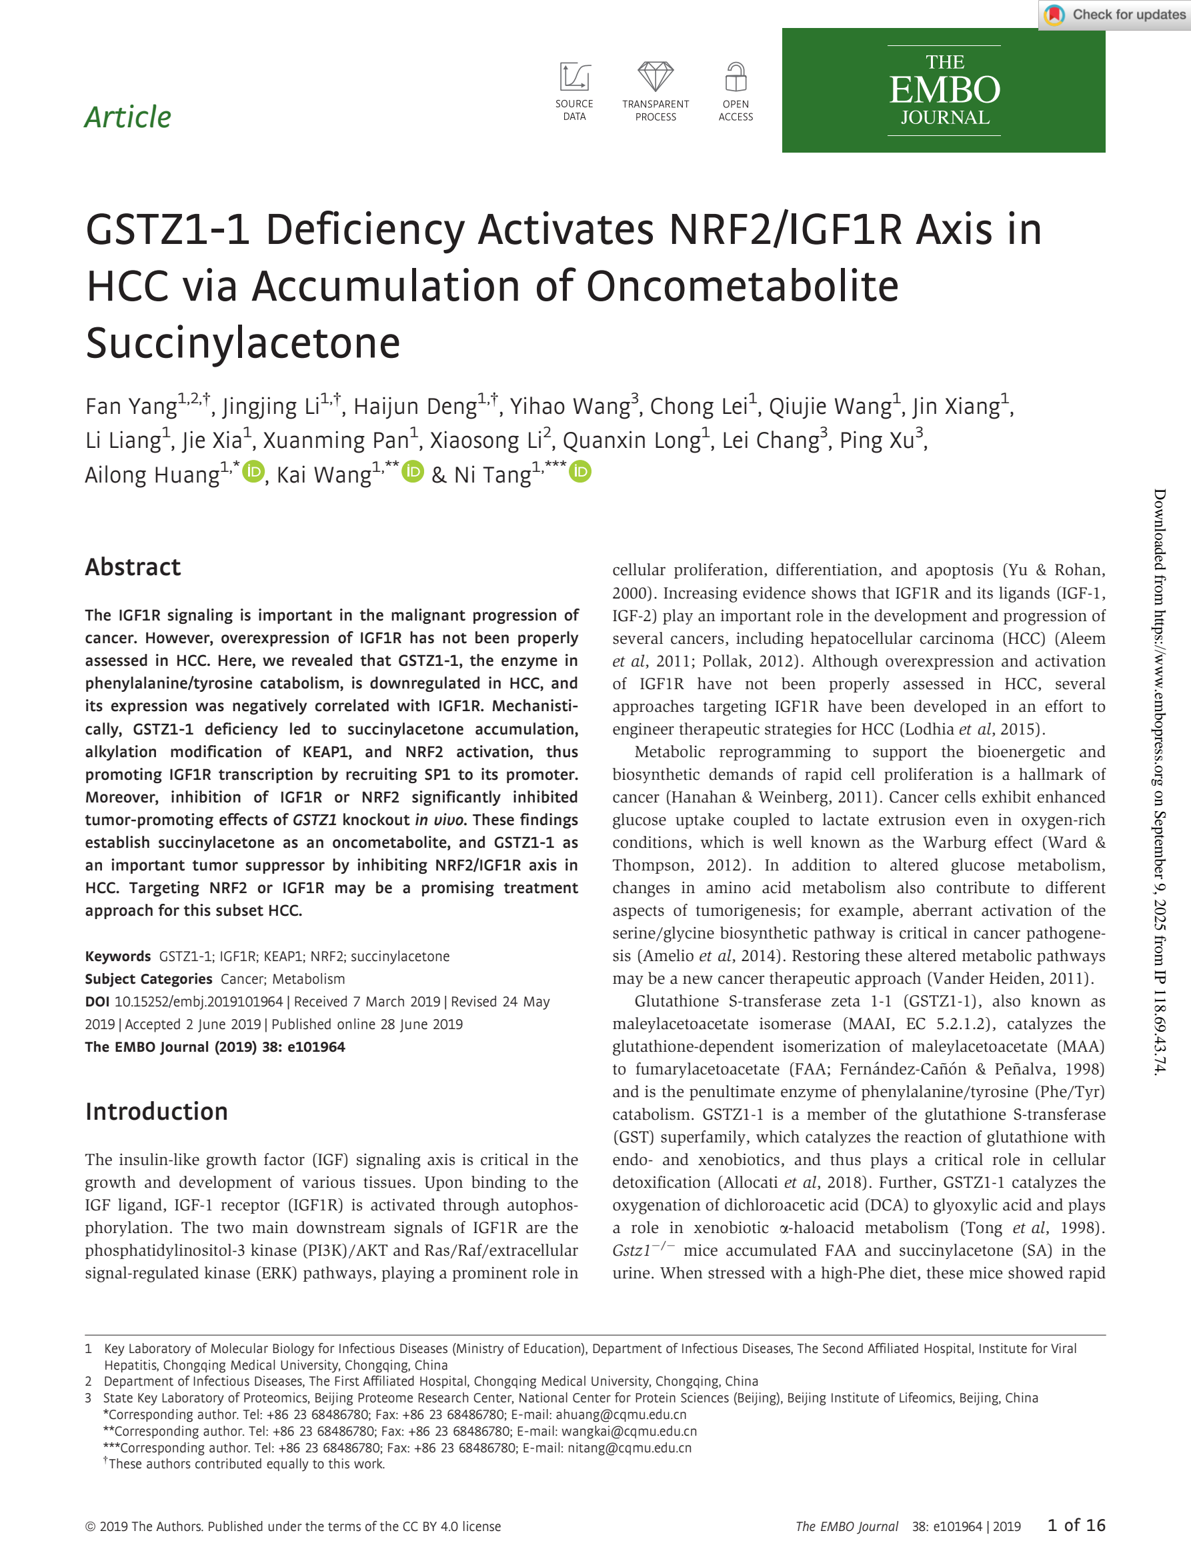

In [27]:
image

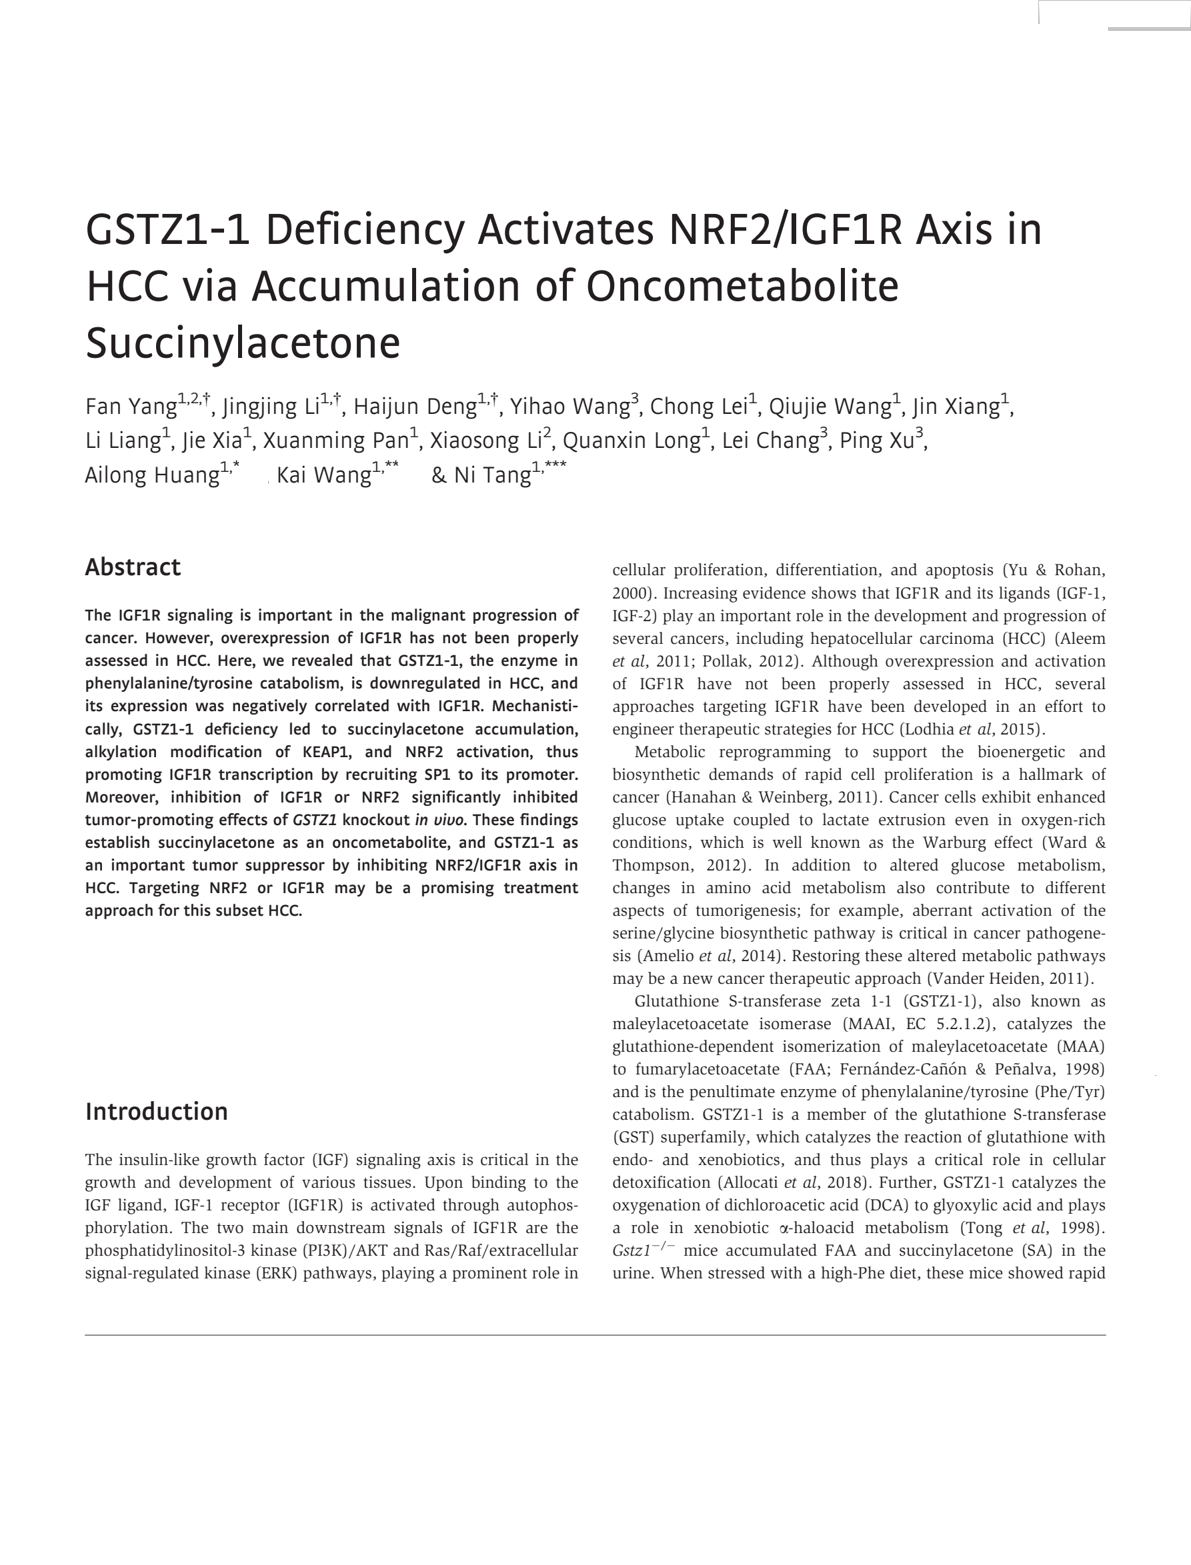

In [28]:
masked_image

In [22]:
def draw_layout_annotations(image: Image.Image, clusters: List[Cluster], 
                          show_labels: bool = True, show_confidence: bool = True) -> Image.Image:
    """
    Draw layout annotations on the page image.
    
    Args:
        image: Page image
        clusters: Layout clusters from analyze_layout()
        show_labels: Whether to show label names
        show_confidence: Whether to show confidence scores
        
    Returns:
        Annotated image
    """
    from PIL import ImageDraw, ImageFont
    import random
    
    # Create a copy to avoid modifying original
    annotated_image = image.copy()
    draw = ImageDraw.Draw(annotated_image)
    
    # Color mapping for different element types
    color_map = {
        DocItemLabel.TEXT: "blue",
        DocItemLabel.SECTION_HEADER: "red", 
        DocItemLabel.TABLE: "green",
        DocItemLabel.PICTURE: "purple",
        DocItemLabel.CAPTION: "orange",
        DocItemLabel.FOOTNOTE: "brown",
        DocItemLabel.PAGE_HEADER: "pink",
        DocItemLabel.PAGE_FOOTER: "pink",
        DocItemLabel.LIST_ITEM: "cyan",
        DocItemLabel.FORMULA: "yellow",
        DocItemLabel.CODE: "gray",
    }
    
    try:
        # Try to use a font (may not be available on all systems)
        font = ImageFont.truetype("arial.ttf", 12)
    except:
        font = ImageFont.load_default()
    
    for cluster in clusters:
        # Get color for this element type
        color = color_map.get(cluster.label, "black")
        
        # Draw bounding box
        bbox = cluster.bbox
        rect = [bbox.l, bbox.t, bbox.r, bbox.b]
        draw.rectangle(rect, outline=color, width=2)
        
        # Add label text
        if show_labels or show_confidence:
            label_text = ""
            if show_labels:
                label_text += cluster.label.value
            if show_confidence:
                if label_text:
                    label_text += f" ({cluster.confidence:.2f})"
                else:
                    label_text = f"{cluster.confidence:.2f}"
            
            # Draw text background
            text_bbox = draw.textbbox((bbox.l, bbox.t), label_text, font=font)
            draw.rectangle(text_bbox, fill=color, outline=color)
            
            # Draw text
            draw.text((bbox.l, bbox.t), label_text, fill="white", font=font)
    
    return annotated_image

In [28]:
image, clusters = analyze_layout("../testdata/01.pdf", page=3)

In [34]:
from PIL import ImageDraw, ImageFont
annotated_image = image.copy()
draw = ImageDraw.Draw(annotated_image)
# Color mapping for different element types
color_map = {
    DocItemLabel.TEXT: "blue",
    DocItemLabel.SECTION_HEADER: "red", 
    DocItemLabel.TABLE: "green",
    DocItemLabel.PICTURE: "purple",
    DocItemLabel.CAPTION: "orange",
    DocItemLabel.FOOTNOTE: "brown",
    DocItemLabel.PAGE_HEADER: "pink",
    DocItemLabel.PAGE_FOOTER: "pink",
    DocItemLabel.LIST_ITEM: "cyan",
    DocItemLabel.FORMULA: "yellow",
    DocItemLabel.CODE: "gray",
}

In [35]:
cluster = clusters[0]
color = color_map.get(cluster.label, "black")

# Draw bounding box
bbox = cluster.bbox
rect = [bbox.l, bbox.t, bbox.r, bbox.b]
draw.rectangle(rect, outline=color, fill=color, width=2)

In [31]:
masked_image.save("masked.png")

# Document Layout Analysis v2

In [41]:
from pathlib import Path
from typing import List, Optional, Tuple
from PIL import Image
import numpy as np
import random

from docling.backend.pypdfium2_backend import PyPdfiumDocumentBackend
from docling.datamodel.document import InputDocument
from docling.datamodel.base_models import InputFormat
from docling.datamodel.accelerator_options import AcceleratorOptions, AcceleratorDevice
from docling.datamodel.pipeline_options import LayoutOptions
from docling.datamodel.base_models import BoundingBox, Cluster
from docling.models.layout_model import LayoutModel
from docling_core.types.doc import DocItemLabel
from PIL import ImageDraw, ImageFont, Image
from tqdm import tqdm


COLOR_MAP = {
    DocItemLabel.TEXT: "blue",
    DocItemLabel.SECTION_HEADER: "red", 
    DocItemLabel.TABLE: "green",
    DocItemLabel.PICTURE: "purple",
    DocItemLabel.CAPTION: "orange",
    DocItemLabel.FOOTNOTE: "brown",
    DocItemLabel.PAGE_HEADER: "pink",
    DocItemLabel.PAGE_FOOTER: "pink",
    DocItemLabel.LIST_ITEM: "cyan",
    DocItemLabel.FORMULA: "yellow",
    DocItemLabel.CODE: "gray",
}

def images_to_pdf(image_list, output_path):    
    # Convert all images to RGB mode (required for PDF)
    rgb_images = []
    for img in image_list:
        if img.mode != 'RGB':
            img = img.convert('RGB')
        rgb_images.append(img)
    
    # Save first image as PDF, append the rest
    rgb_images[0].save(
        output_path, 
        format='PDF', 
        save_all=True, 
        append_images=rgb_images[1:]
    )

def analyze_layout(
    input_doc: InputDocument, 
    page: int = 0,
    layout_model: str = None, 
    scale: float = 3.0
) -> Tuple[Image.Image, List[Cluster]]:
    
    # 1. Load specific page
    backend = input_doc._backend
    page_backend = backend.load_page(page)
    assert page_backend.is_valid()
    
    # 2. Get page image (this is what the layout model expects)
    page_image = page_backend.get_page_image(scale=scale)
    page_size = page_backend.get_size()
    
    # 3. Run layout prediction
    predictions = layout_model.layout_predictor.predict_batch([page_image])
    page_predictions = predictions[0]
    
    # 4. Convert predictions to clusters
    clusters = []
    for ix, pred_item in enumerate(page_predictions):
        # Convert label string to DocItemLabel enum
        label_str = pred_item["label"].lower().replace(" ", "_").replace("-", "_")
        label = DocItemLabel(label_str)
        
        cluster = Cluster(
            id=ix,
            label=label,
            confidence=pred_item["confidence"],
            bbox=BoundingBox.model_validate(pred_item),
            cells=[]
        )
        clusters.append(cluster)
    
    # 5. Cleanup
    # page_backend.unload()
    # backend.unload()
    
    return page_image, clusters

def mask_page(
    image: Image.Image, 
    clusters: List[Cluster],
    allowed_labels: List[str]
):
    # Create a copy to avoid modifying original
    annotated_image = image.copy()
    draw = ImageDraw.Draw(annotated_image)

    for cluster in clusters:
        if cluster.label in allowed_labels: continue
            
        # Masking unwanted components
        color = "white"
        bbox = cluster.bbox
        rect = [bbox.l, bbox.t, bbox.r, bbox.b]
        draw.rectangle(rect, fill=color)
        
    return annotated_image

def mask_file(
    input_file_path, output_file_path,
    layout_model,
    allowed_labels = [DocItemLabel.TEXT, DocItemLabel.SECTION_HEADER]
):
    # 2. Load PDF using InputDocument (it handles backend internally)
    file_path = Path(input_file_path)
    input_doc = InputDocument(
        path_or_stream=file_path,
        format=InputFormat.PDF,
        backend=PyPdfiumDocumentBackend
    )
    if not input_doc.valid:
        raise ValueError(f"Document {file_path} is not valid")   
        
    backend = input_doc._backend
    page_count = backend.page_count()
    print("page count:", page_count)
    images, masked_images = [], []
    for page in tqdm(range(page_count)):
        image, clusters = analyze_layout(input_doc, page, layout_model)
        masked_image = mask_page(image, clusters, allowed_labels)
        images.append(image)
        masked_images.append(masked_image)

    output_file = Path(output_file_path)
    images_to_pdf(masked_images, output_file)
    # output_dir.mkdir(parents=True, exist_ok=True)
    # for i, img in enumerate(masked_images):
    #     img.save(output_dir / f"page_{i:02d}.png")

    return image, masked_images

In [7]:
## RUN
layout_model = LayoutModel(
    artifacts_path=None,  # Will auto-download models
    accelerator_options=AcceleratorOptions(
        num_threads=32, 
        device=AcceleratorDevice.AUTO
    ),
    options=LayoutOptions()  # Use default layout options
)

In [42]:
if __name__ == "__main__":
    ## INPUT that need argparse
    input_file_path = "../testdata/05.pdf"
    output_file_path = "./masked.pdf"
    images, masked_images = mask_file(input_file_path, output_file_path, layout_model)

page count: 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.36it/s]


In [43]:
masked_images

[<PIL.Image.Image image mode=RGB size=1786x2347>,
 <PIL.Image.Image image mode=RGB size=1786x2347>,
 <PIL.Image.Image image mode=RGB size=1786x2347>,
 <PIL.Image.Image image mode=RGB size=1786x2347>,
 <PIL.Image.Image image mode=RGB size=1786x2347>,
 <PIL.Image.Image image mode=RGB size=1786x2347>,
 <PIL.Image.Image image mode=RGB size=1786x2347>,
 <PIL.Image.Image image mode=RGB size=1786x2347>,
 <PIL.Image.Image image mode=RGB size=1786x2347>,
 <PIL.Image.Image image mode=RGB size=1786x2347>,
 <PIL.Image.Image image mode=RGB size=1786x2347>,
 <PIL.Image.Image image mode=RGB size=1786x2347>,
 <PIL.Image.Image image mode=RGB size=1786x2347>,
 <PIL.Image.Image image mode=RGB size=1786x2347>,
 <PIL.Image.Image image mode=RGB size=1786x2347>,
 <PIL.Image.Image image mode=RGB size=1786x2347>]